
# Ссылка на Kaggle
https://www.kaggle.com/vankapro

# Dependencies

In [11]:
# Импортируем необходимые библиотеки:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.model_selection import train_test_split # специальный инструмент для разбивки

# Data

In [12]:
data = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
data['Sample'] = 1 # помечаем где у нас трейн
df_test['Sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

#объединяем
data = df_test.append(data, sort=False).reset_index(drop=True)

In [13]:
# Заполним пропуски нулевым значением
data['Number of Reviews'].fillna(1, inplace=True)
#Поменяем этот параметр на числовое представление.
data['Price Range'] = data['Price Range'].map({'$': 0, '$$ - $$$': 1, '$$$$': 2})
# Заполним пропуски медианным значением
data['Price Range'].fillna(data['Price Range'].median(), inplace=True)

In [14]:
data['Reviews'] = data['Reviews'].str.replace('nan', 'None').fillna('[[], []]').transform(literal_eval)
# Сделаем даты отзывов отдельными признаками, это позволит ввести новые параметры.
reviews_dates = data['Reviews'].str[1].apply(pd.to_datetime)
reviews_dates = reviews_dates.apply(lambda dates: (dates.min(), dates.max()))
data[['Previous Review Date', 'Last Review Date']] = pd.DataFrame(reviews_dates.to_list(), index=data.index)

In [15]:
# Cоздаём новый параметр дней после последнего отзыва.
last_review_ago = data['Last Review Date'].max() - data['Last Review Date']
data['Last Review Ago'] = last_review_ago.dt.days
# Заполним пропуски максимальным значением.
data['Last Review Ago'].fillna(data['Last Review Ago'].max(), inplace=True)
# Cоздаём новый параметр разницы дней между отзывами.
reviews_interval = data['Last Review Date'] - data['Previous Review Date']
data['Days Between Reviews'] = reviews_interval.dt.days
# Заполним пропуски максимальным значением.
data['Days Between Reviews'].fillna(data['Days Between Reviews'].max(), inplace=True)

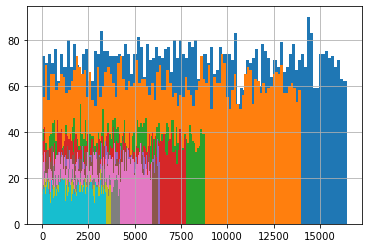

In [16]:
# Посмотрим на распределение ранга по городам.
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

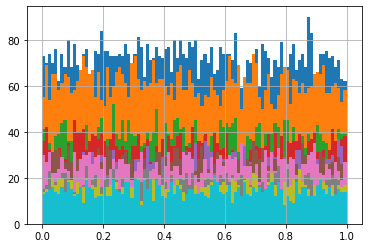

In [17]:
# Нормируем ранг и создаём новый параметр
cities_max_ranking = data.groupby('City')['Ranking'].max()
data['Scaled Ranking'] = data[['City', 'Ranking']].apply(lambda row: row['Ranking'] / cities_max_ranking[row['City']], axis=1)
# Посмотрим на распределение нормированного ранга по городам.
for x in (data['City'].value_counts())[0:10].index:
    data['Scaled Ranking'][data['City'] == x].hist(bins=100)
plt.show()

<AxesSubplot:>

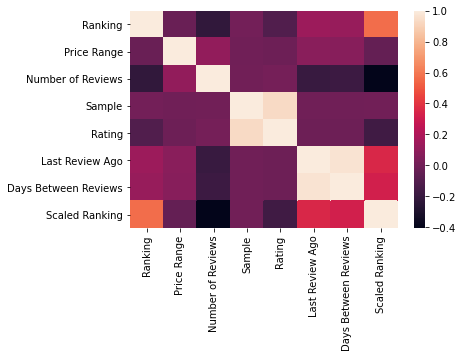

In [18]:
corr = data.corr()
sns.heatmap(corr)

In [19]:
# Cоздаём dummy переменные из Городов и Кухонь.
data = pd.concat([data, pd.get_dummies(data['City'])], axis=1)
                 
data['Cuisine Style'] = data['Cuisine Style'].fillna('["General"]').transform(literal_eval)
data = pd.concat([data, pd.get_dummies(data['Cuisine Style'].explode()).groupby(level=0).sum()], axis=1)

In [20]:
# Cоздаём новый параметр количества предлагаемых кухонь в ресторане.
data['Cuisine Сount'] = data['Cuisine Style'].str.len()

In [21]:
# Добавляем новые данные. Весь этот блок и информация по городам полностью позаимствованы из блокнота с лучшей моделью.
countries = dict(city=["London", "Paris", "Lyon", "Madrid", "Barcelona", "Berlin", "Hamburg",
                       "Munich", "Milan", "Rome", "Prague", "Lisbon", "Oporto",
                       "Vienna", "Amsterdam", "Brussels", "Stockholm", "Budapest",
                       "Warsaw", "Krakow", "Dublin", "Copenhagen", "Athens", "Edinburgh",
                       "Zurich", "Geneva", "Oslo", "Helsinki", "Bratislava",
                       "Luxembourg", "Ljubljana"],

                 wage=[2280, 3084, 3084, 1900, 1900, 3750, 3750,
                           3750, 2434, 2434, 1146, 815, 815,
                           2700, 2152, 2500, 2650, 763,
                           900, 900, 2200, 5390, 1811, 2000,
                           5789, 5789, 4420, 3400, 1100,
                           4308, 1593],

                 pop=[8.797, 2.188, 0.516, 6.477, 5.474, 3.539, 1.791, 1.464, 1.352,
                          2.873, 1.281, 2.913, 1.304, 1.868, 0.845, 2.034, 1.553, 1.752,
                          1.759, 0.766, 1.348, 0.602, 3.157, 0.513, 0.403, 0.490, 0.667,
                          0.630, 0.438, 0.122, 0.293],

                 gpd=[2.500, 2.295, 2.295, 1.162, 1.162, 3.245, 3.245, 3.245, 1.737,
                          1.737, 0.192, 0.196, 0.196, 0.370, 0.738, 0.446, 0.480, 0.126,
                          0.467, 0.467, 0.297, 0.292, 0.180, 0.165, 0.557, 0.557, 0.326,
                          0.226, 0.085, 0.057, 0.043],

                 temp=[11.10, 11.30, 11.60, 13.70, 16.50, 9.100, 8.500, 8.000, 13.10,
                          15.70, 9.000, 16.90, 14.40, 9.900, 9.200, 10.30, 7.000, 11.00,
                          7.700, 8.200, 9.700, 8.400, 18.10, 8.500, 9.300, 10.30, 6.300,
                          5.100, 9.700, 9.100, 10.40],

                 num_vis=[19.5565, 17.7951, 5.0000, 5.35005, 7.45725, 5.4497, 2.0000,
                          4.65830, 7.06565, 8.5927, 7.37930, 3.58470, 2.3413,
                          6.55015, 8.17710, 3.3260, 2.34230, 3.59140,
                          2.11000, 1.91600, 5.0917, 2.34985, 4.20420, 2.0000,
                          2.62000, 1.32500, 1.0000, 2.00000, 1.50000,
                          1.00000, 0.90000],

                 capital=[1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
                          1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

countries = pd.DataFrame(countries)
countries.set_index("city", inplace=True)

data.append(pd.DataFrame(columns=["num_visd", "capital", "pop",
                                  "gpd", "temp", "wage"], dtype="float64"))

i = 0

for elem in data["City"]:
    data.at[i, 'num_vis'] = countries["num_vis"][elem]
    data.at[i, 'capital'] = countries["capital"][elem]
    data.at[i, 'pop'] = countries["pop"][elem]
    data.at[i, 'gpd'] = countries["gpd"][elem]
    data.at[i, 'temp'] = countries["temp"][elem]
    data.at[i, 'wage'] = countries["wage"][elem]

    i += 1

data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Sample,...,Wine Bar,Xinjiang,Yunnan,Cuisine Сount,num_vis,capital,pop,gpd,temp,wage
0,id_0,Paris,"[Bar, Pub]",12963.0,1.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,2,17.7951,1.0,2.188,2.295,11.3,3084.0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,1.0,97.0,"[[Very good reviews!, Fine dining in Hakaniemi...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,5,2.0000,1.0,0.630,0.226,5.1,3400.0
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,1.0,28.0,"[[Better than the Links, Ivy Black], [12/28/20...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,1,2.0000,1.0,0.513,0.165,8.5,2000.0
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,2.0,202.0,"[[Most exquisite, Delicious and authentic], [1...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,5,19.5565,1.0,8.797,2.500,11.1,2280.0
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,2.0,162.0,"[[Always the best in bratislava, Very good but...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,6,1.5000,1.0,0.438,0.085,9.7,1100.0


# Model

In [22]:
train_data = data.query('Sample == 1').drop(['Sample'], axis=1)
test_data = data.query('Sample == 0').drop(['Sample'], axis=1)
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = train_data.drop(['Restaurant_id', 'Rating', 'City','Cuisine Style','Reviews','URL_TA','ID_TA','Previous Review Date', 'Last Review Date'], axis = 1)
y = train_data['Rating']
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [23]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)
# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)
y_pred = np.around(2*y_pred, 0)/2

In [24]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1685


# Submission

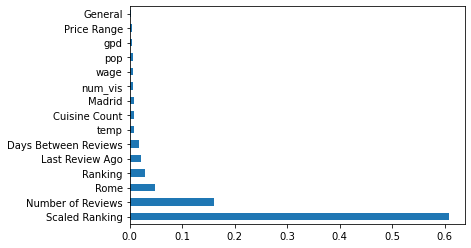

In [25]:
key_params = pd.Series(regr.feature_importances_, index=X.columns)
key_params.nlargest(15).plot(kind='barh');

In [26]:
X = test_data.drop(['Restaurant_id', 'Rating', 'City','Cuisine Style','Reviews','URL_TA','ID_TA','Previous Review Date', 'Last Review Date'], axis = 1)
pred = regr.predict(X)
pred = np.around(2*pred, 0)/2
sample_submission['Rating'] = pred
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.0
